In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import statsmodels.formula.api as sm

# black magic
%matplotlib inline

We'll also need the timezone package, to deal with times in UTC.

In [2]:
import pytz

## Start by Preparing the Temperature Data

In [3]:
# Load
df = pd.read_csv("weather_2013-2016")

# Drop a few bogus values
df = df[df['TemperatureF'] != -9999.0]
df["PrecipitationIn"].fillna(0, inplace = True)

# Set the time as the index and resample
df = df.set_index(pd.DatetimeIndex(df['DateUTC']))

**Let's convert from UTC to Central Time.**

This must follow the resampling, since there's a bug in resampling over DST borders.

In [4]:
ts_utc = df.index.tz_localize(pytz.UTC)
df = df.set_index(ts_utc.tz_convert(pytz.timezone('US/Central')))

N.B., faster, less readable resampling alternative:

```
df = df.set_index(pd.DatetimeIndex(df['DateUTC']).tz_localize(pytz.UTC))
df = df.resample('2H').mean()
df = df.set_index(df.index.tz_convert(pytz.timezone('US/Central')))
```

In [5]:
evening_temp = df[df.index.hour >= 18]
evening_temp_agg = evening_temp.groupby(evening_temp.index.date).mean()
evening_temp_agg.index.rename("Date", inplace = True)

evening_temp_agg[["TemperatureF", "PrecipitationIn"]]\
  .rename(columns = {"TemperatureF" : "Temperature [F]", "PrecipitationIn" : "Precipitation [In]"})\
  .to_csv("evening_temp_agg.csv")

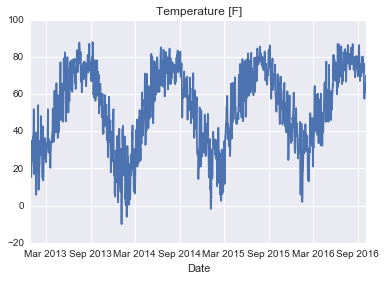

In [6]:
evening_temp_agg.plot(use_index = True, y = "TemperatureF", legend = False, title = 'Temperature [F]')

## Now Prepare Crime on the Same Index

In [7]:
if False: # Do this from scratch -- long operation

    crime_df = pd.read_csv("chicago_crime.csv", parse_dates = {'time': ['Date']}, index_col = 'time')
    crime_df = crime_df[crime_df['Primary Type'] != 'DECEPTIVE PRACTICE']

    crime_cases = crime_df[['Case Number']]
    evening_crime = crime_cases[crime_cases.index.hour >= 18]
    evening_crime_agg = evening_crime.groupby(pd.DatetimeIndex(evening_crime.index.date)).count()
    evening_crime_agg.index.rename("Date", inplace = True)
    
    evening_crime_agg.to_csv("evening_crime_agg.csv")


`# crime_df = crime_df.set_index(pd.DatetimeIndex(crime_df['Date']).tz_localize(pytz.timezone('US/Central'))`

In [8]:
evening_crime_agg = pd.read_csv("evening_crime_agg.csv", index_col = 'Date', parse_dates = ['Date'])

## Now Merge Them

In [19]:
merge_df = evening_crime_agg.join(evening_temp_agg[['TemperatureF', 'PrecipitationIn']])
merge_df.rename(columns={'TemperatureF': 'Temperature [F]', 'Case Number': 'Number of Crimes', 'PrecipitationIn':'Precipitation [In]'}, inplace=True)

### Plot it.

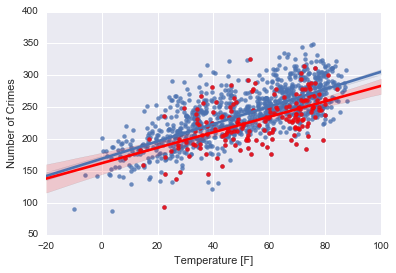

In [20]:
fig, ax = plt.subplots()
sns.regplot(data = merge_df, x = 'Temperature [F]', y = "Number of Crimes", ax = ax)
sns.regplot(data = merge_df[merge_df['Precipitation [In]'] != 0], x = 'Temperature [F]', y = "Number of Crimes", color = 'r', ax = ax)

In [22]:
stats.ttest_ind(merge_df[merge_df['Precipitation [In]'] == 0]["Number of Crimes"], 
                merge_df[merge_df['Precipitation [In]'] != 0]["Number of Crimes"])

Ttest_indResult(statistic=3.4708474397967426, pvalue=0.0005390740882446263)

### Which Days of the Week are Worst?

,Number of Crimes,Temperature [F],Precipitation [In],Day of Week
0,232.115385,51.490079,0.010954,0
1,234.898089,50.651849,0.007449,1
2,234.299363,49.871607,0.004195,2
3,233.101911,50.408592,0.005913,3
4,262.692308,50.990413,0.002594,4
5,246.326923,51.732189,0.004448,5
6,228.653846,52.401167,0.004715,6


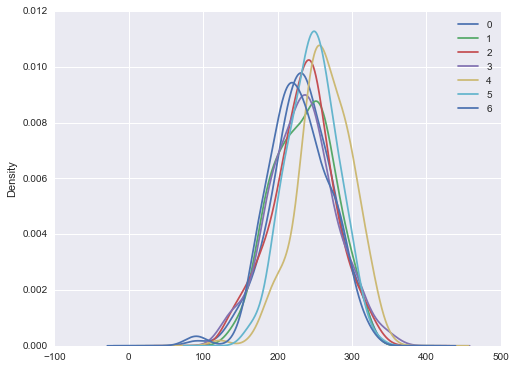

In [11]:
merge_df['Day of Week'] = merge_df.index.dayofweek

fig, ax = plt.subplots(figsize=(8,6))
for label, df in merge_df.groupby(merge_df.index.dayofweek):
    df.plot(kind = 'kde', sharex = True, x = 'Day of Week', y = 'Number of Crimes', ax=ax, label=label)

merge_df.groupby(merge_df.index.dayofweek).mean()

### Create Lagged Shift Column

In [12]:
merge_df['Lagged Shift [F]'] = merge_df['Temperature [F]'] - merge_df['Temperature [F]'].rolling(window = 3, center = False).mean().shift(1)

merge_df['Split Window [F]'] = merge_df['Temperature [F]'] - \
                                0.5 * (merge_df['Temperature [F]'].rolling(window = 3, center = False).mean().shift(-3) +
                                       merge_df['Temperature [F]'].rolling(window = 3, center = False).mean().shift(1))

merge_df.dropna(inplace = True)
    
# merge_df = evening_crime_agg.join(evening_temp_agg[['Lagged Shift [F]', "PrecipitationIn"]])
# merge_df.rename(columns={'Case Number': 'Number of Crimes'}, inplace=True)
# merge_df.plot(kind='scatter', x = 'Lagged Shift [F]', y = 'Number of Crimes')

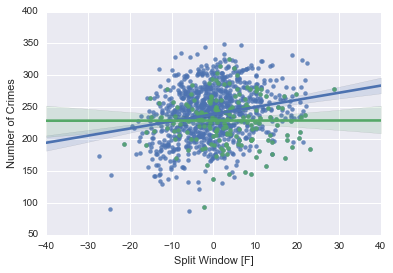

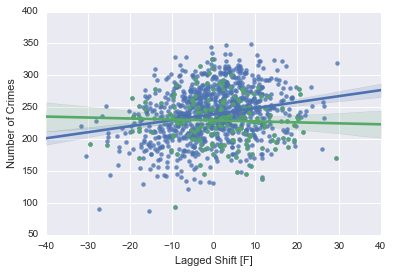

In [13]:
fig, ax = plt.subplots()
sns.regplot(data = merge_df, x = 'Split Window [F]', y = "Number of Crimes", ax = ax)
sns.regplot(data = merge_df[merge_df['Precipitation [In]'] != 0], x = 'Split Window [F]', y = "Number of Crimes", ax = ax)

fig, ax = plt.subplots()
sns.regplot(data = merge_df, x = 'Lagged Shift [F]', y = "Number of Crimes", ax = ax)
sns.regplot(data = merge_df[merge_df['Precipitation [In]'] != 0], x = 'Lagged Shift [F]', y = "Number of Crimes", ax = ax)

In [14]:
merge_df.rename(columns={'Lagged Shift [F]' : 'ShiftF', 'Number of Crimes' : 'NCrimes'}, inplace=True)

model = sm.ols(formula = 'NCrimes ~ ShiftF', data = merge_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NCrimes   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     54.34
Date:                Tue, 18 Oct 2016   Prob (F-statistic):           3.34e-13
Time:                        21:59:21   Log-Likelihood:                -5560.1
No. Observations:                1089   AIC:                         1.112e+04
Df Residuals:                    1087   BIC:                         1.113e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    239.0551      1.211    197.461      0.000       236.680   241.431
ShiftF         0.9436      0.128      7.371      0.000         0.692     1.195
==============================================================================
Omnibus:                        6.080   Durbin-Watson:                   0.713
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                6.149
Skew:                          -0.183   Prob(JB):                       0.0462
Kurtosis:                       2.952   Cond. No.                         9.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
slope, intercept, r_value, p_value, std_err = stats.linregress(merge_df['ShiftF'], merge_df['NCrimes'])
print(slope/std_err)

7.37132153965


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120ee88d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e4c3f28>]], dtype=object)

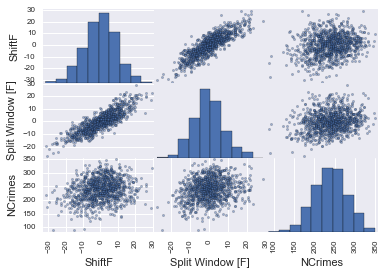

In [73]:
pd.tools.plotting.scatter_matrix(merge_df[['ShiftF', 'Split Window [F]', 'NCrimes']])